## Part I: Data Pre-processing

In [1]:
import pandas as pd

In [ ]:
# shihtl> Local download.
# # Download the Google Analogy dataset
# !wget http://download.tensorflow.org/data/questions-words.txt

In [2]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [3]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [9]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.
questions = []
categories = []
sub_categories = []

now_sub_categories_idx = 0
now_sub_categories = ""
now_category = ""
for entry in data:
    if entry.startswith(": "):
        now_sub_categories_idx += 1
        now_sub_categories = entry
        now_category = "Semantic" if now_sub_categories_idx <= 5 else "Syntatic"
    else:
        questions.append(entry)
        categories.append(now_category)
        sub_categories.append(now_sub_categories)


In [10]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [18]:
df.head(8870)  # shihtl> First Syntatic Category

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries
...,...,...,...
8865,uncle aunt sons daughters,Semantic,: family
8866,uncle aunt stepbrother stepsister,Semantic,: family
8867,uncle aunt stepfather stepmother,Semantic,: family
8868,uncle aunt stepson stepdaughter,Semantic,: family


In [19]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [35]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [36]:
data = pd.read_csv("questions-words.csv")

In [8]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

The Gensim model loaded successfully!


In [37]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

# shihtl> preds_cache
try:
      cache = pd.read_csv("preds_cache.csv")
      preds = list(cache.preds)
      golds = list(cache.golds)
except:
      for analogy in tqdm(data["Question"]):
            # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
            # You should also preserve the gold answers during iterations for evaluations later.
            """ Hints
            # Unpack the analogy (e.g., "man", "woman", "king", "queen")
            # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
            # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
            # Mikolov et al., 2013: big - biggest and small - smallest
            # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
            """
            word_a, word_b, word_c, word_d = map(str.lower, analogy.split())
            this_pred = model.most_similar([word_b, word_c], word_a, topn=1)[0][0]
            
            preds.append(this_pred)
            golds.append(word_d)

      # shihtl> preds_cache
      preds_cache = pd.DataFrame({
            "preds": preds,
            "golds": golds
      })
      preds_cache.to_csv("preds_cache.csv", index=False)

100%|██████████| 19544/19544 [04:26<00:00, 73.24it/s]


In [38]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 65.3399481339497%
Category: Syntatic, Accuracy: 61.255269320843084%
Sub-Category: capital-common-countries, Accuracy: 93.87351778656127%
Sub-Category: capital-world, Accuracy: 88.94783377541998%
Sub-Category: currency, Accuracy: 14.203233256351039%
Sub-Category: city-in-state, Accuracy: 30.806647750304013%
Sub-Category: family, Accuracy: 81.62055335968378%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category: gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category: gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category: gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category: gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category: gram6-nationality-adjective, Accuracy: 87.86741713570981%
Sub-Category: gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category: gram8-plural, Accuracy: 71.996996996997%
Sub-Category: gram9-plural-verbs, Accuracy: 58.39080459770115%


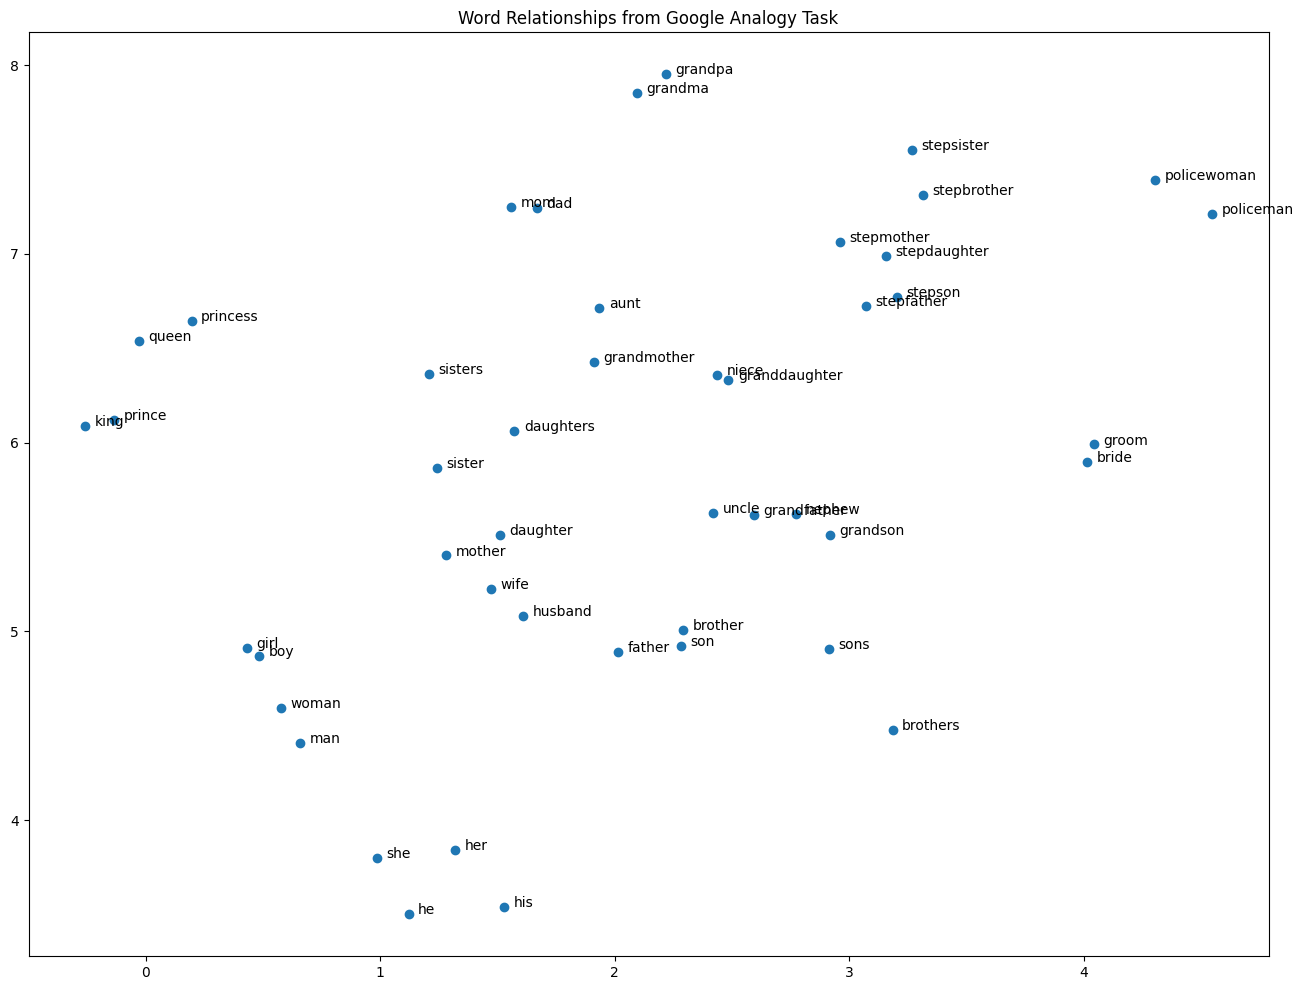

In [40]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
sub_category_data = data[data.SubCategory == SUB_CATEGORY]
sub_category_data_str = " ".join(sub_category_data.Question)
words = np.unique(np.array(sub_category_data_str.split()))
# print(words[:10])

X = np.array([model[word] for word in words])
# print(X[0])

embedded = TSNE().fit_transform(X)
# print(embedded[:5, :])

plt.figure(figsize=(16, 12))
plt.scatter(embedded[:, 0], embedded[:, 1])

for idx, dots in enumerate(embedded):
    plt.annotate(words[idx], (dots[0] + 0.04, dots[1]))

plt.title("Word Relationships from Google Analogy Task")
plt.savefig("word_relationships.png", bbox_inches="tight")
plt.show()

## Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [ ]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [ ]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [ ]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [57]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random
import math

wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
RANDOM_SEED = 38457190
RANDOM_PERCENT = 0.2
random.seed(RANDOM_SEED)
input_path = f"wiki_texts_random_{RANDOM_SEED}_{RANDOM_PERCENT}.txt"

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(input_path, "w", encoding="utf-8") as output_file:
        # TODO4: Sample `20%` Wikipedia articles
        # Write your code here

        # shihtl> This section of code is for line counting, but this file is too large to count (consume too much time).
        # shihtl> I use !wc to count lines once.
        line_count = 5623655
        # line_count = 0
        # for sentence in f:
        #     line_count += 1
        # f.seek(0)

        num_line_select = math.floor(line_count * RANDOM_PERCENT)
        num_line_not_select = line_count - num_line_select    # shihtl> 避免除不盡算錯數量，不使用 line_count * (1 - RANDOM_PERCENT)
        line_mask = [True] * num_line_select + [False] * num_line_not_select

        random.shuffle(line_mask)

        for mask in tqdm(line_mask):
            sentence = f.readline()
            if mask == True:
                output_file.write(sentence)

100%|██████████| 5623655/5623655 [00:56<00:00, 100128.22it/s]


In [51]:
print("borbón ".isascii())
print("borbn ".isascii())

s = "borbón borbón borbn borbón borbón borbón borbón borbn borbón borbón borbón borbón"
res = list(filter(str.isascii, s.split()))
print(list(res))

False
True
['borbn', 'borbn']


In [58]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
# shihtl> Preprocessing data
# shihtl> 1) remove non ascii word directly
RANDOM_SEED = 38457190
RANDOM_PERCENT = 0.2

input_path = f"wiki_texts_random_{RANDOM_SEED}_{RANDOM_PERCENT}.txt"
output_path = f"wiki_texts_random_{RANDOM_SEED}_{RANDOM_PERCENT}_preprocessed.txt"
with open(input_path, "r", encoding="utf-8") as ifile, open(output_path, "w", encoding="utf-8") as ofile:
    for line in tqdm(ifile):
        res_list = list(filter(str.isascii, line.split()))
        ofile.write(" ".join(res_list))
        ofile.write("\n")

1124731it [02:25, 7723.63it/s] 


In [59]:
from gensim.models import Word2Vec


# shihtl> Settings for model
USE_PRETRAIN_MODEL = False
SAVE_MODEL_PATH = "./wiki_texts_random_38457190_0.2.model"
LOAD_MODEL_PATH = "./wiki_texts_random_38457190_0.2.model"
FILE_PATH = "./wiki_texts_random_38457190_0.2_preprocessed.txt"

if USE_PRETRAIN_MODEL:
    my_model = Word2Vec.load(LOAD_MODEL_PATH)
else:
    my_model = Word2Vec(corpus_file=FILE_PATH, vector_size=50)
    my_model.save(SAVE_MODEL_PATH)


In [60]:
data = pd.read_csv("questions-words.csv")

In [63]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

# shihtl> preds_cache
try:
      cache = pd.read_csv("preds_cache_my_model.csv")
      preds = list(cache.preds)
      golds = list(cache.golds)
except:
      for analogy in tqdm(data["Question"]):
            # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
            # You should also preserve the gold answers during iterations for evaluations later.
            """ Hints
            # Unpack the analogy (e.g., "man", "woman", "king", "queen")
            # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
            # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
            # Mikolov et al., 2013: big - biggest and small - smallest
            # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
            """
            word_a, word_b, word_c, word_d = map(str.lower, analogy.split())
            this_pred = my_model.wv.most_similar([word_b, word_c], word_a, topn=1)[0][0]
            
            preds.append(this_pred)
            golds.append(word_d)

      # shihtl> preds_cache
      preds_cache = pd.DataFrame({
            "preds": preds,
            "golds": golds
      })
      preds_cache.to_csv("preds_cache_my_model.csv", index=False)

100%|██████████| 19544/19544 [08:13<00:00, 39.64it/s]


In [65]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 50.10711466907205%
Category: Syntatic, Accuracy: 39.00702576112412%
Sub-Category: capital-common-countries, Accuracy: 73.3201581027668%
Sub-Category: capital-world, Accuracy: 64.50044208664897%
Sub-Category: currency, Accuracy: 8.660508083140877%
Sub-Category: city-in-state, Accuracy: 28.779894608836642%
Sub-Category: family, Accuracy: 73.12252964426878%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 13.306451612903224%
Sub-Category: gram2-opposite, Accuracy: 11.576354679802956%
Sub-Category: gram3-comparative, Accuracy: 53.52852852852853%
Sub-Category: gram4-superlative, Accuracy: 27.183600713012478%
Sub-Category: gram5-present-participle, Accuracy: 29.071969696969695%
Sub-Category: gram6-nationality-adjective, Accuracy: 74.85928705440901%
Sub-Category: gram7-past-tense, Accuracy: 36.02564102564102%
Sub-Category: gram8-plural, Accuracy: 38.06306306306306%
Sub-Category: gram9-plural-verbs, Accuracy: 39.88505747126437%


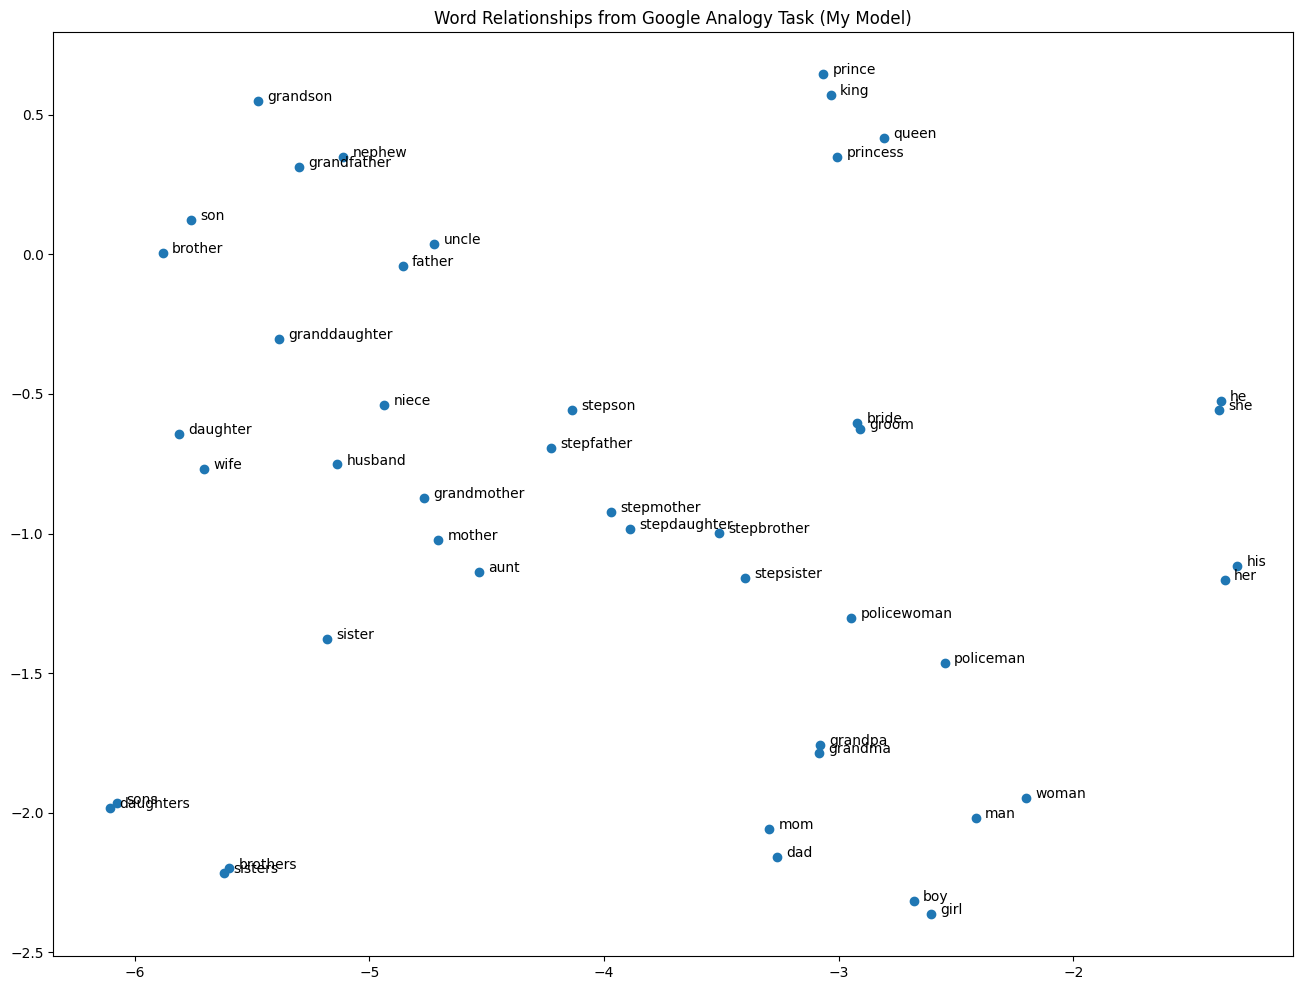

In [64]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`
sub_category_data = data[data.SubCategory == SUB_CATEGORY]
sub_category_data_str = " ".join(sub_category_data.Question)
words = np.unique(np.array(sub_category_data_str.split()))
# print(words[:10])

X = np.array([my_model.wv[word] for word in words])
# print(X[0])

embedded = TSNE().fit_transform(X)
# print(embedded[:5, :])

plt.figure(figsize=(16, 12))
plt.scatter(embedded[:, 0], embedded[:, 1])

for idx, dots in enumerate(embedded):
    plt.annotate(words[idx], (dots[0] + 0.04, dots[1]))

plt.title("Word Relationships from Google Analogy Task (My Model)")
plt.savefig("word_relationships_my_model.png", bbox_inches="tight")
plt.show()